In [445]:
# auxiliary functions
import plotly
import numpy as np
import random
import plotly.graph_objs as go

def show_pointcloud(pcl, colors, points_to_show = 10000):
    if len(pcl.shape) == 3:
        assert len(colors.shape) == 3
        pcl = pcl.reshape(3, -1)
        colors = colors.reshape(3, -1)
    assert pcl.shape[0] == 3
    assert colors.shape[0] == 3
    assert pcl.shape[1] == colors.shape[1]
    if pcl.shape[1] > points_to_show:
        random_sample = random.sample(list(range(pcl.shape[1])), points_to_show)
        pcl = pcl[:, random_sample]
        colors = colors[:, random_sample]

    # Configure Plotly to be rendered inline in the notebook.
    plotly.offline.init_notebook_mode()

    # Configure the trace.
    trace = go.Scatter3d(
      x=pcl[0],
      y=pcl[1],
      z=pcl[2],
      mode='markers',
      marker={
          'size': 5,
          'opacity': 1,
          'color': colors.transpose()
      }
    )

    # Configure the layout.
    layout = go.Layout(
      margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )
    #up=dict(x=0, y=0, z=1),
    #center=dict(x=0, y=0, z=0),
    #eye=dict(x=0.1, y=0.1, z=2.5)
    
    camera = dict(
        up=dict(x=0, y=-1, z=0),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=0, y=0.3, z=-1.5)
    )

    layout.update(scene=dict(camera=camera))

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)
    configure_plotly_browser_state()

    # Render the plot.
    plotly.offline.iplot(plot_figure)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
def show_image(img, title=None, normalize=False):
    if len(img.shape) == 2:
        img = np.tile(img[None,:,:], (3,1,1))
        
    img = img.transpose((1,2,0))
    if normalize:
        img = img*1.0
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img*255.0, dtype='uint8')
    plt.figure()
    if not title is None:
        plt.title(title)
    _ = plt.imshow(img)

    
def imread(img_file):
    return cv2.imread(img_file)[:,:,::-1].transpose((2,0,1))
    
img = np.zeros((3,3,3))
colors = np.zeros((3,3,3))
visualize_pointcloud_inline(img, colors)


In [446]:
from auxiliary_functions import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


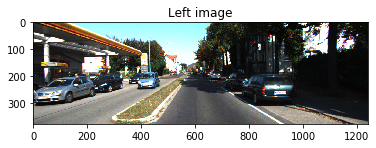

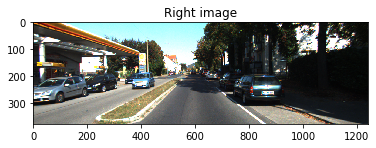

In [447]:
# Load the images and the ground truth depth that we will use throughout the PSET
img_L = imread("data/000191_10_L.png")
img_R = imread("data/000191_10_R.png")
K_gt = np.load("data/000191_K.npy")
img_L_cv2 = img_L.transpose((1,2,0))
img_R_cv2 = img_R.transpose((1,2,0))
show_image(img_L, title="Left image")
show_image(img_R, title="Right image")
# show_image(img_R - img_L, title="Difference image", normalize=True)


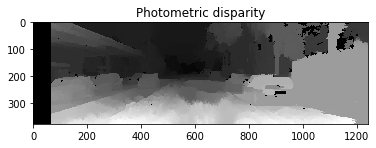

In [448]:
# First, we will compute disparities using photometric matching and Opencv built in
# Opencv SGBM algorithm: 
# Based on: http://timosam.com/python_opencv_depthimage 

window_size = 3
min_disp = 1
max_disp = 1 + 16*4   # max_disp - min_disp has to be dividable by 16
left_matcher = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=max_disp - min_disp,
    blockSize=5,
    P1=8 * 3 * window_size ** 2,
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
dispr = right_matcher.compute(img_R_cv2, img_L_cv2)

# FILTER of the disparity based on left/right consistency
lmbda = 80000
sigma = 1.2
visual_multiplier = 1.0

wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

displ = wls_filter.filter(displ, img_L_cv2, None, dispr)
disparity = np.array(displ, dtype=np.float32)/16
valid_disparity = disparity != -1
#depth = 1/disparity
show_image(disparity, title='Photometric disparity', normalize=True)


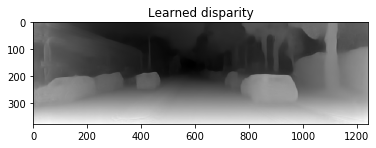

In [449]:
# Model from:
# https://github.com/mrharicot/monodepth
disparity_learned = np.load('precomputed_results/computed_disparity.npy')
# Resize to the same size of the original image
disparity_learned = cv2.resize(disparity_learned, (img_L.shape[2],img_L.shape[1]))
depth_learned = 1/disparity_learned
show_image(disparity_learned, title='Learned disparity', normalize=True)

In [450]:
# Assuming that the horizontal field of view of the camera is 105 degrees, and the center of projection 
# is the center of the image complete the missing values of the intrinsics matrix.
img_height, img_width = img_L.shape[1:3]
FOV = np.deg2rad(105)
f_x = img_width/np.tan(FOV/2) #...
f_y = img_width/np.tan(FOV/2) #...
c_x = img_width/2 #...
c_y = img_height/2 #...
K = np.array(((f_x, 0, c_x),
             (0, f_y, c_y),
             (0,   0,   1)))

In [451]:
# compute the pointcloud for a z_map = 1
def backproject_depth_to_pointcloud(K, depth):
    height, width = depth.shape
    img_coordinates = np.array(np.meshgrid(np.arange(0,width), np.arange(0,height)))
    #imshow(img_coordinates[1])
    #print(img_coordinates[1].max())
    img_coordinates = np.concatenate((img_coordinates, np.ones((1, *depth.shape))))
    #show_image(img_coordinates, normalize=True)
    
    img_coordinates_flattened = img_coordinates.reshape(3,-1)
    depth_flattened = depth.flatten()
    K_inv = np.linalg.inv(K)

    cam_coordinates = np.matmul(K_inv, img_coordinates_flattened)
    
    point_cloud = cam_coordinates * depth_flattened

    # Reshape to depth shape
    point_cloud = point_cloud.reshape((3, *depth.shape))
    return point_cloud

depth_learned[depth_learned > 25] = 25
point_cloud_learned = backproject_depth_to_pointcloud(K_gt, depth_learned)


In [472]:
# now compute for the computed z_maps
show_pointcloud(point_cloud_learned, img_L)

In [ ]:
show_pointcloud(point_cloud_learned, img_L)

In [464]:
# Finally, compare the pointcloud obtained with the groundtruth K and the approximated K.
point_cloud_disparity = backproject_pointcloud(K_gt, img_L)
point_cloud_nyu = backproject_pointcloud(K_gt, img_L)

NameError: name 'backproject_pointcloud' is not defined